<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segment-the-nucleis" data-toc-modified-id="Segment-the-nucleis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segment the nucleis</a></span></li><li><span><a href="#Segment-cells" data-toc-modified-id="Segment-cells-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Segment cells</a></span></li></ul></div>

In [2]:
import re
import random
import omero
from pandas import DataFrame, merge,concat
import numpy as np

from skimage import segmentation,filters,morphology,measure,feature
from skimage.color import label2rgb
from scipy.ndimage.morphology import binary_fill_holes, binary_closing
from skimage.util import img_as_ubyte,img_as_float
from skimage.exposure import rescale_intensity

from scipy.stats import kurtosis, skew

import omero
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
plt.set_cmap('gray')


<Figure size 432x288 with 0 Axes>

In [3]:
# Connect to the server
def connect(hostname, username, password):
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    print("Connected: %s" % conn.connect())
    conn.c.enableKeepAlive(60)
    return conn


In [4]:
def getBulkAnnotationAsDf(screenID, conn):
    ofId = None
    sc = conn.getObject('Screen', screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName() == 'bulk_annotations'):
                if (ann.getFile().getSize()> 1476250900): #about 140Mb?
                    print("that's a big file...")
                    return None
                ofId = ann.getFile().getId()
                break

    if ofId is None:
        return None

    original_file = omero.model.OriginalFileI(ofId, False)

    table = conn.c.sf.sharedResources().openTable(original_file)
    count = 0
    try:
        rowCount = table.getNumberOfRows()

        column_names = []
        pattern = re.compile("Phenotype \d+$")
        for col in table.getHeaders():
            column_names.append(col.name)
            if pattern.match(col.name) is not None:
                count = count + 1

        black_list = []
        column_indices = []
        for column_name in column_names:
            if column_name in black_list:
                continue
            column_indices.append(column_names.index(column_name))

        table_data = table.slice(column_indices, None)
    finally:
        table.close()

    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn = DataFrame(data)
    dfAnn.columns = column_names
    return dfAnn, count

def getOneImage(conn,weid,pos=None):
    we = conn.getObject('Well',weid)
    if pos==None:
        pos=random.choice(range(we.countWellSample()))  # one random field of that well
        
    im = we.getImage(pos)   
    pix = im.getPrimaryPixels()
    I1=pix.getPlane(0,0,0)
    I2=pix.getPlane(0,1,0)
    I3=pix.getPlane(0,2,0)
    I4=pix.getPlane(0,3,0)
    I5=pix.getPlane(0,4,0)
    I=np.stack([I1,I2,I3,I4,I5],2)
    return I


In [5]:
host = "ws://idr.openmicroscopy.org/omero-ws"
username = "public"
password = "public"
screenId = 1751 #idr0033-rohban-pathways/screenA

# Connect to the server
conn = connect(host, username, password)

# Downloading the annotation file for the whole screen
# as a panda DataFrame
dfAnn, phenotype_count = getBulkAnnotationAsDf(screenId, conn)


Connected: True


In [6]:

weid=dfAnn[dfAnn['Control Type']=='negative control'].sample()['Well'].values
I=getOneImage(conn,weid)


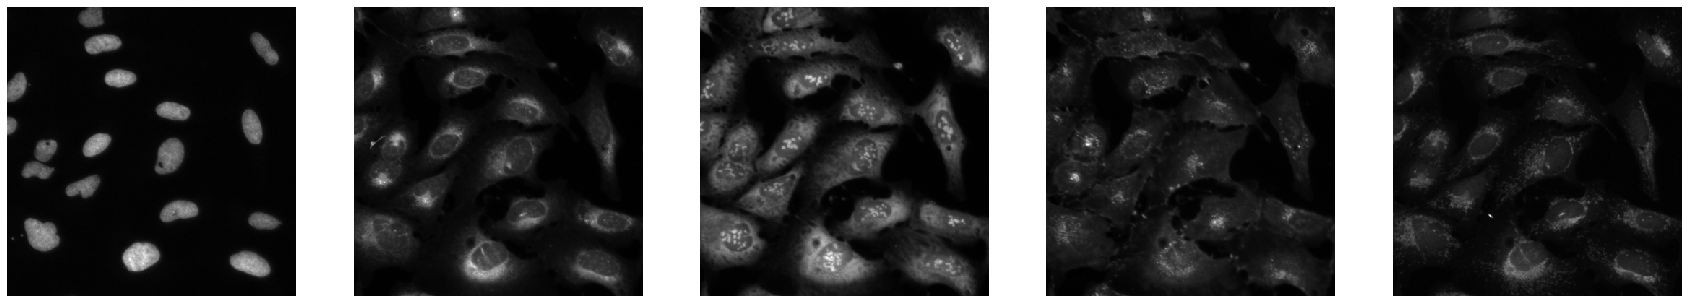

In [7]:
zoomx=[100,500]
zoomy=[100,500]
fig,ax=plt.subplots(1,5,figsize=(30,10))
ax[0].imshow(I[:,:,0][zoomx[0]:zoomx[1],zoomy[0]:zoomy[1]])
ax[1].imshow(I[:,:,1][zoomx[0]:zoomx[1],zoomy[0]:zoomy[1]])
ax[2].imshow(I[:,:,2][zoomx[0]:zoomx[1],zoomy[0]:zoomy[1]])
ax[3].imshow(I[:,:,3][zoomx[0]:zoomx[1],zoomy[0]:zoomy[1]])
ax[4].imshow(I[:,:,4][zoomx[0]:zoomx[1],zoomy[0]:zoomy[1]])

for x in ax.ravel():
    x.axis("off")

In [9]:
I[:,:,0]

array([[2419, 2355, 2548, ...,  554,  531,  513],
       [2532, 2519, 2441, ...,  549,  596,  515],
       [2415, 2535, 2452, ...,  503,  548,  525],
       ...,
       [ 578,  581,  585, ...,  534,  540,  525],
       [ 535,  624,  520, ...,  521,  557,  570],
       [ 583,  567,  561, ...,  548,  543,  545]], dtype=uint16)

## Segment the nucleis

1. Starting from the DAPI image (the first, index 0), buils a binary image with nucleis only.

2. Use skimage.measure.label and skimage.measure.regionprops to extract a data frame of nucleis objects with preliminary geometric measurement. Use simple manual threshold to remove outliers objects.


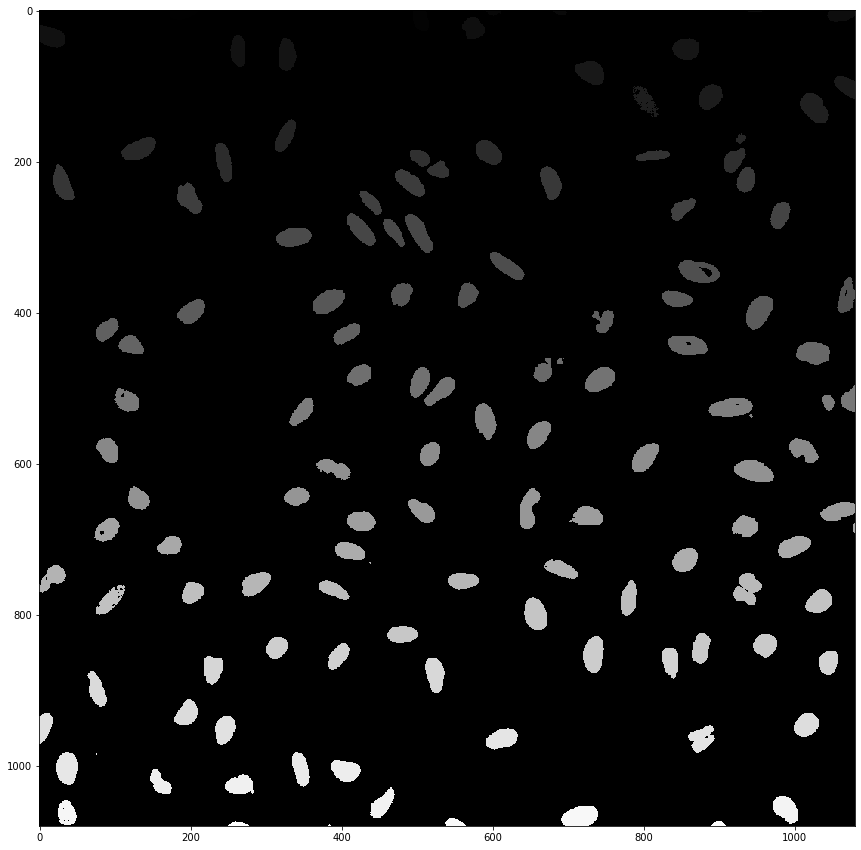

In [7]:
#initial seg: plain thresholding of dapi channel
otsu=filters.threshold_otsu(I[:,:,0])
dapiSeg=measure.label(I[:,:,0]>otsu)

plt.figure(figsize=(15,15))
plt.imshow(dapiSeg)

In [18]:
rp=measure.regionprops(dapiSeg)

#Also measure.regionprops_table()

label=[]
bbox=[]
center=[]
area=[]
eccentricity=[]
equivalent_diameter=[]
moments_hu=[]
perimeter=[]
solidity=[]
for r in rp:
    try:
        label.append(r.label)
        bbox.append(r.bbox)
        center.append(r.centroid)
        area.append(r.area)
        eccentricity.append(r.eccentricity)
        equivalent_diameter.append(r.equivalent_diameter)
        moments_hu.append(r.moments_hu)
        perimeter.append(r.perimeter)
        solidity.append(r.solidity)
    except:
        print('whut')
        continue

nucs=DataFrame({'labels':label,'nucleus_bbox':bbox,'nucleus_center':center,'nucleus_area':area,'nucleus_eccentricity':eccentricity,'nucleus_equivalent_diameter':equivalent_diameter,'nucleus_moments_hu':moments_hu,'nucleus_perimeter':perimeter,'nucleus_solidity':solidity})


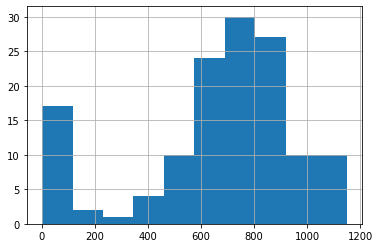

In [21]:
nucs.nucleus_area.hist()

In [22]:
nucs=nucs[nucs.nucleus_area>400]

In [12]:
dfAnn['Channels'][0]


'Hoechst 33342:nucleus;concanavalin A/AlexaFluor488 conjugate:endoplasmic reticulum;SYTO14 green fluorescent nucleic acid stain:nucleoli and cytoplasmic RNA;wheat germ agglutinin/AlexaFluor594 conjugate (WGA):Golgi apparatus and plasma membrane;phalloidin/AlexaFluor594 conjugate:F_actin;MitoTracker Deep Red:mitochondria'

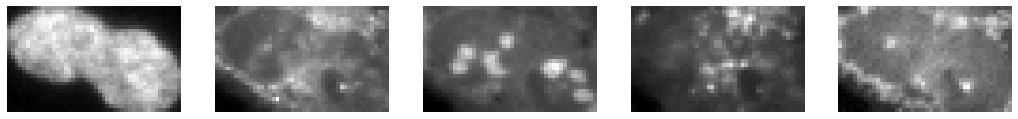

In [23]:
nrow=np.random.choice(len(nucs))
bb=nucs['nucleus_bbox'].iloc[nrow]
            
fig, axes = plt.subplots(1, 5,figsize=(18, 3))
axes[0].imshow(I[bb[0]:bb[2],bb[1]:bb[3],0])
axes[1].imshow(I[bb[0]:bb[2],bb[1]:bb[3],1])
axes[2].imshow(I[bb[0]:bb[2],bb[1]:bb[3],2])
axes[3].imshow(I[bb[0]:bb[2],bb[1]:bb[3],3])
axes[4].imshow(I[bb[0]:bb[2],bb[1]:bb[3],4])

for x in axes.ravel():
    x.axis("off")


## Segment cells

3. Similarly, try to segment the cell body using the third channel (index 2)

3. With nucleis as seed, use the watershed segmentation algorithm (skimage.morphology.watershed) to segment single cells. (use the 'mask' option.)

4. Again use regionprops to extract objects and geometric features and clean them.

3. use skimage.segmentation.clear_border to remove object touching the border

4. Manually look at segmented objects for selected phenotypes to check that the segmentation is robust.



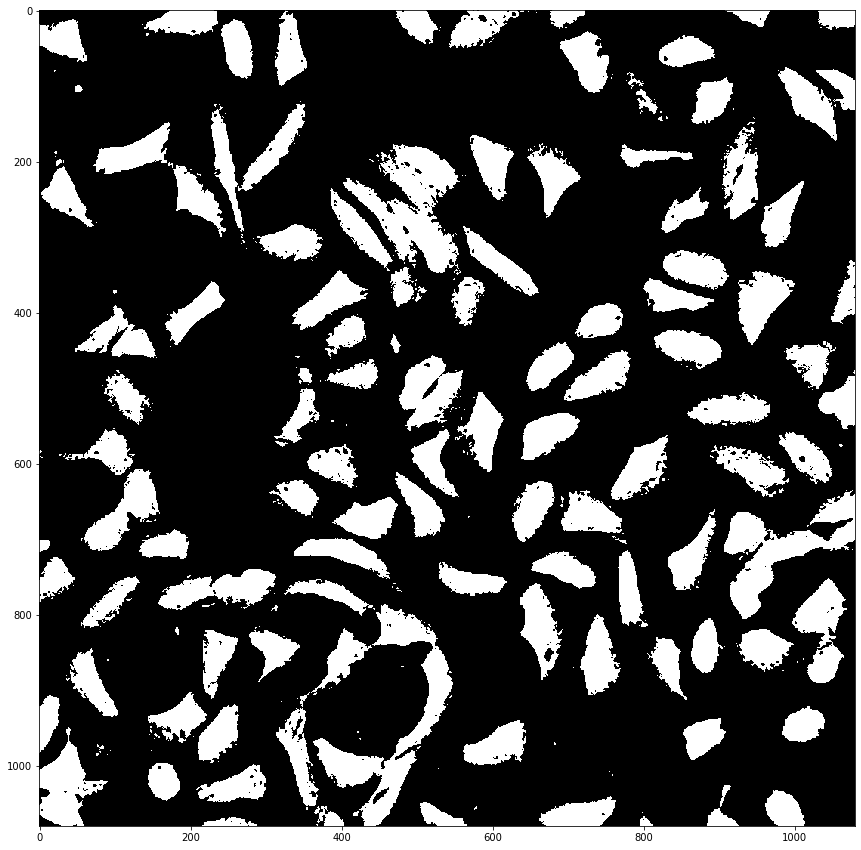

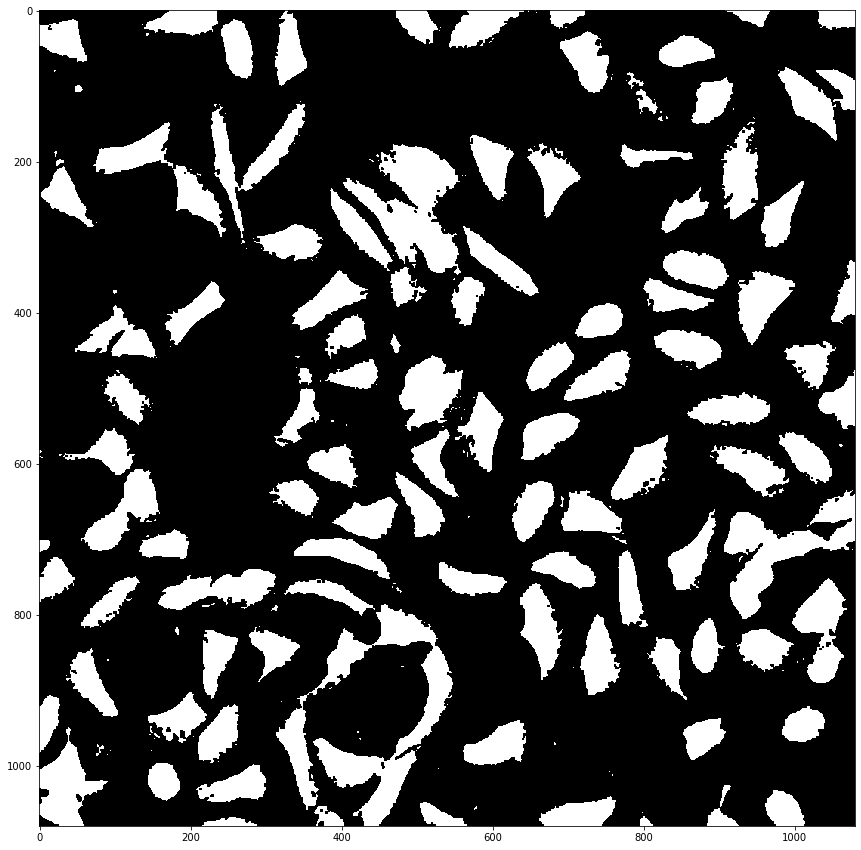

In [24]:

amaskRaw=I[:,:,2]> filters.threshold_otsu(I[:,:,2])
amask=morphology.closing(binary_fill_holes(I[:,:,2]> filters.threshold_otsu(I[:,:,2])), morphology.square(3))

plt.figure(figsize=(15,15))
plt.imshow(amaskRaw)
plt.figure(figsize=(15,15))
plt.imshow(amask)


/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


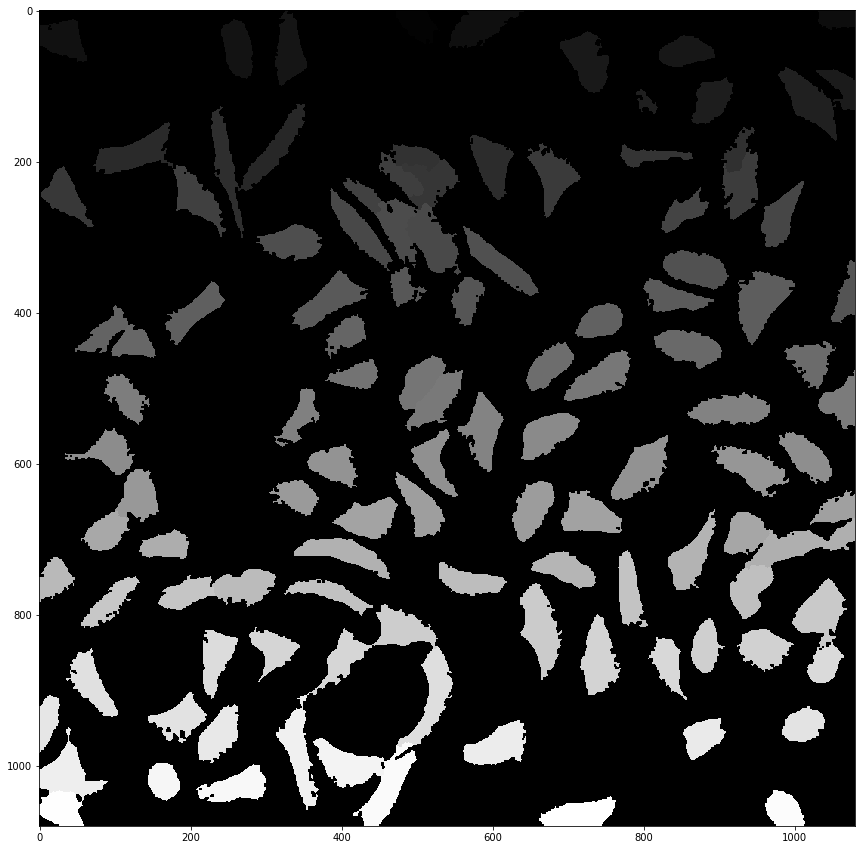

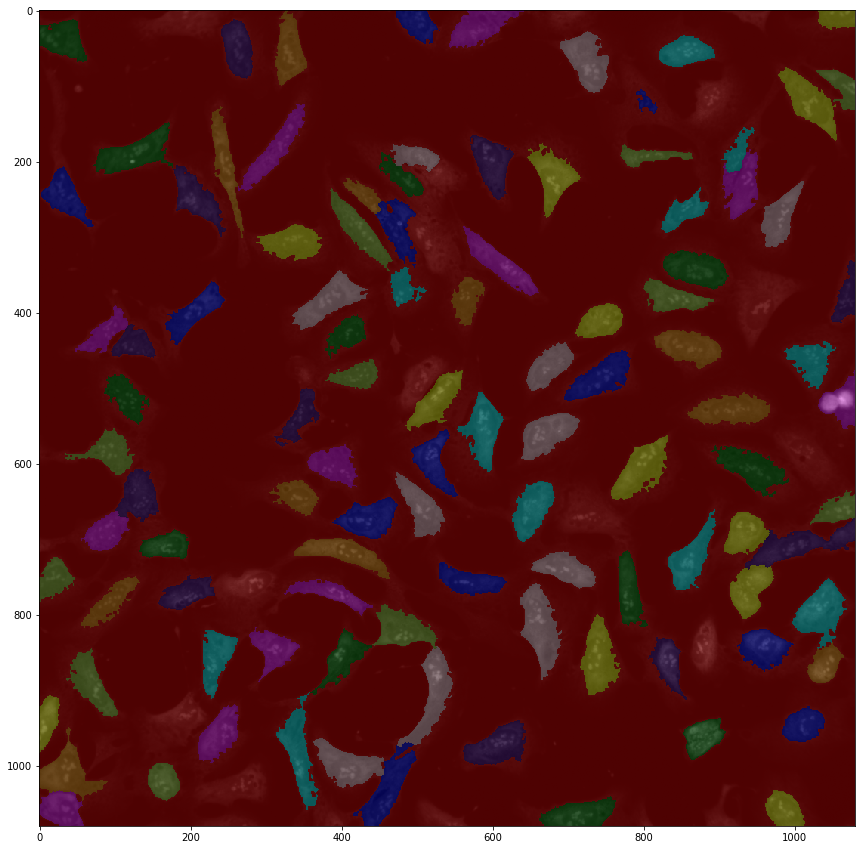

In [54]:

#watershed of channel 2 for cell outline, seeds as dapi centers
markers=np.zeros(I.shape[0:2])
for i,r in nucs.iterrows():
    markers[int(r.nucleus_center[0]),int(r.nucleus_center[1])]=r.labels

seg=segmentation.watershed(-I[:,:,2],markers=markers,mask=amask)

seg_visu=label2rgb(seg,image=I[:,:,2])



plt.figure(figsize=(15,15))
plt.imshow(seg)

plt.figure(figsize=(15,15))
plt.imshow(seg_visu)


/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  after removing the cwd from sys.path.
/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


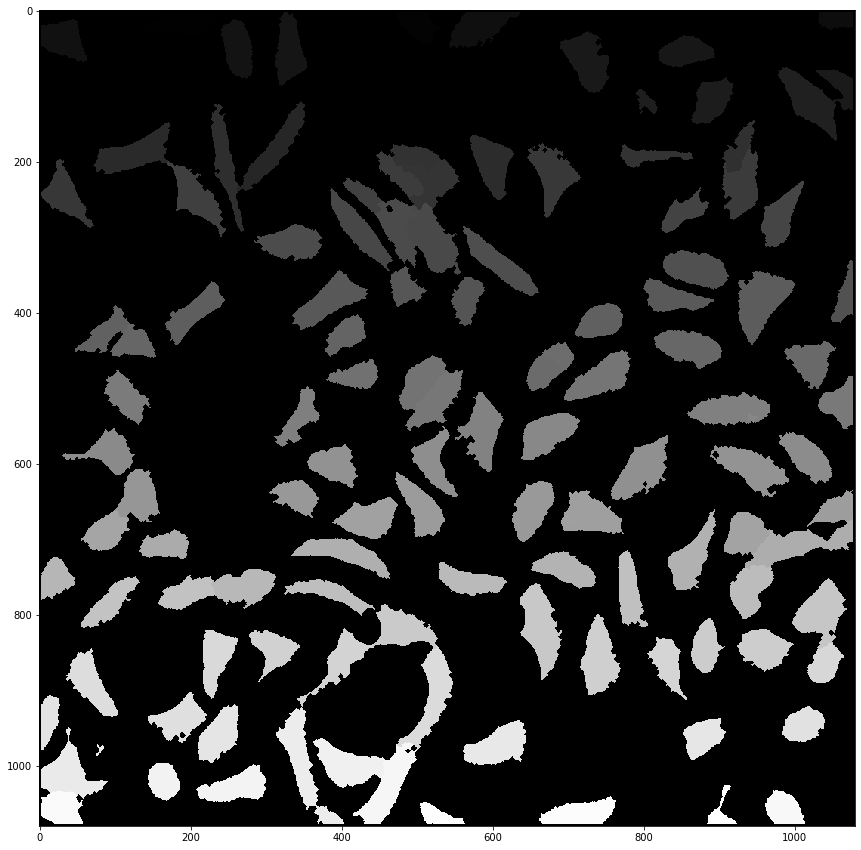

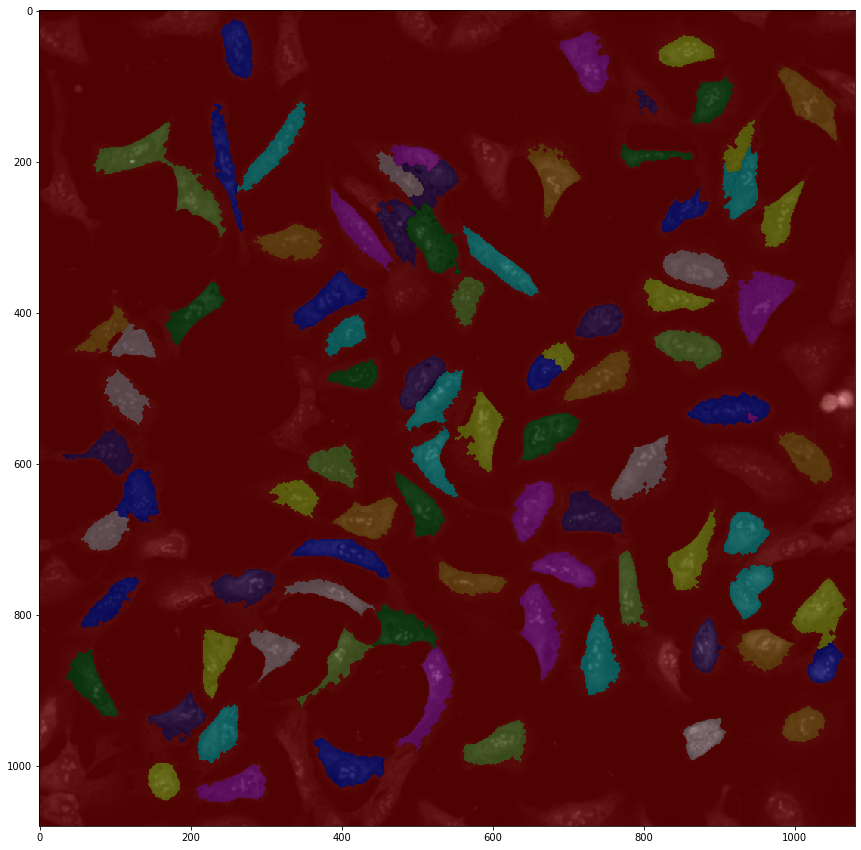

In [53]:

#cytoSegTouchesBorders=seg-segmentation.clear_border(seg,buffer_size=3) #watershed add a border of 3
#cytoSegTouchesBorders=np.unique(cytoSegTouchesBorders[cytoSegTouchesBorders>0]-1) #row in df is zero based

rp2=measure.regionprops(seg, coordinates='rc')
label=[]
bbox=[]
center=[]
area=[]
eccentricity=[]
equivalent_diameter=[]
moments_hu=[]
perimeter=[]
solidity=[]
for r in rp2:
    try:
        label.append(r.label)
        bbox.append(r.bbox)
        center.append(r.centroid)
        area.append(r.area)
        eccentricity.append(r.eccentricity)
        equivalent_diameter.append(r.equivalent_diameter)
        moments_hu.append(r.moments_hu)
        perimeter.append(r.perimeter)
        solidity.append(r.solidity)
    except:
        print('whut')
        continue

cells=DataFrame({'labels':label,'cell_bbox':bbox,'cell_center':center,'cell_area':area,'cell_eccentricity':eccentricity,'cell_equivalent_diameter':equivalent_diameter,'cell_moments_hu':moments_hu,'cell_perimeter':perimeter,'cell_solidity':solidity})
dfCells=merge(nucs,cells,how='outer',on='labels')

dfCells.set_index('labels',inplace=True)

#dfCells.drop(cytoSegTouchesBorders,inplace=True)




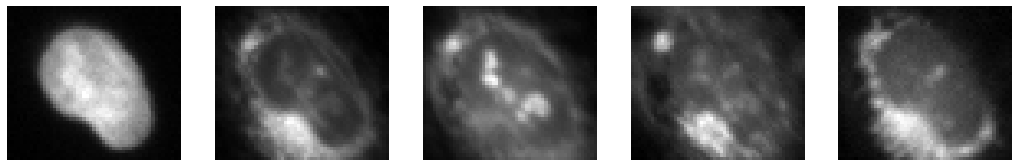

In [49]:
nrow=np.random.choice(len(dfCells))
bb=dfCells.cell_bbox.iloc[nrow]
            
fig, axes = plt.subplots(1, 5,figsize=(18, 3))
axes[0].imshow(I[bb[0]:bb[2],bb[1]:bb[3],0])
axes[1].imshow(I[bb[0]:bb[2],bb[1]:bb[3],1])
axes[2].imshow(I[bb[0]:bb[2],bb[1]:bb[3],2])
axes[3].imshow(I[bb[0]:bb[2],bb[1]:bb[3],3])
axes[4].imshow(I[bb[0]:bb[2],bb[1]:bb[3],4])

for x in axes.ravel():
    x.axis("off")


In [50]:

def segImage(I,param={}):
    #initial seg: plain thresholding of dapi channel
    otsu=filters.threshold_otsu(I[:,:,0])
    dapiSeg=measure.label(I[:,:,0]>otsu)

    dapiSegTouchesBorders=dapiSeg-segmentation.clear_border(dapiSeg)
    dapiSegTouchesBorders=np.unique(dapiSegTouchesBorders.flatten())
    #rp=skimes.regionprops(segmentation.clear_border(skimes.label(I[:,:,0]>otsu)))
    rp=measure.regionprops(dapiSeg, coordinates='rc') #better removing them latter?
    label=[]
    bbox=[]
    center=[]
    area=[]
    eccentricity=[]
    equivalent_diameter=[]
    moments_hu=[]
    perimeter=[]
    solidity=[]
    for r in rp:
        try:
            label.append(r.label)
            bbox.append(r.bbox)
            center.append(r.centroid)
            area.append(r.area)
            eccentricity.append(r.eccentricity)
            equivalent_diameter.append(r.equivalent_diameter)
            moments_hu.append(r.moments_hu)
            perimeter.append(r.perimeter)
            solidity.append(r.solidity)
        except:
            print('whut')
            continue

    nucs=DataFrame({'labels':label,'nucleus_bbox':bbox,'nucleus_center':center,'nucleus_area':area,'nucleus_eccentricity':eccentricity,'nucleus_equivalent_diameter':equivalent_diameter,'nucleus_moments_hu':moments_hu,'nucleus_perimeter':perimeter,'nucleus_solidity':solidity})


    #watershed of channel 2 for cell outline, seeds as dapi centers
    markers=np.zeros(I.shape[0:2])
    for i,r in nucs.iterrows():
        markers[int(r.nucleus_center[0]),int(r.nucleus_center[1])]=r.labels

    amask=binary_closing(binary_fill_holes(I[:,:,2]> filters.threshold_otsu(I[:,:,2])),iterations=3)
    seg=segmentation.watershed(-I[:,:,2],markers=markers,mask=amask)

    cytoSegTouchesBorders=seg-segmentation.clear_border(seg,buffer_size=3) #watershed add a border of 3
    cytoSegTouchesBorders=np.unique(cytoSegTouchesBorders[cytoSegTouchesBorders>0]-1) #row in df is zero based

    rp2=measure.regionprops(seg, coordinates='rc')
    label=[]
    bbox=[]
    center=[]
    area=[]
    eccentricity=[]
    equivalent_diameter=[]
    moments_hu=[]
    perimeter=[]
    solidity=[]
    for r in rp2:
        try:
            label.append(r.label)
            bbox.append(r.bbox)
            center.append(r.centroid)
            area.append(r.area)
            eccentricity.append(r.eccentricity)
            equivalent_diameter.append(r.equivalent_diameter)
            moments_hu.append(r.moments_hu)
            perimeter.append(r.perimeter)
            solidity.append(r.solidity)
        except:
            print('whut')
            continue

    cells=DataFrame({'labels':label,'cell_bbox':bbox,'cell_center':center,'cell_area':area,'cell_eccentricity':eccentricity,'cell_equivalent_diameter':equivalent_diameter,'cell_moments_hu':moments_hu,'cell_perimeter':perimeter,'cell_solidity':solidity})

    dfCells=merge(nucs,cells,how='outer',on='labels')
    dfCells.drop(cytoSegTouchesBorders,inplace=True)
    
    seg_visu=label2rgb(segmentation.clear_border(seg,buffer_size=3),image=I[:,:,2])

    return dfCells,seg,seg_visu


/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  if __name__ == '__main__':
/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
/home/ac/anaconda3/envs/bio583/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_

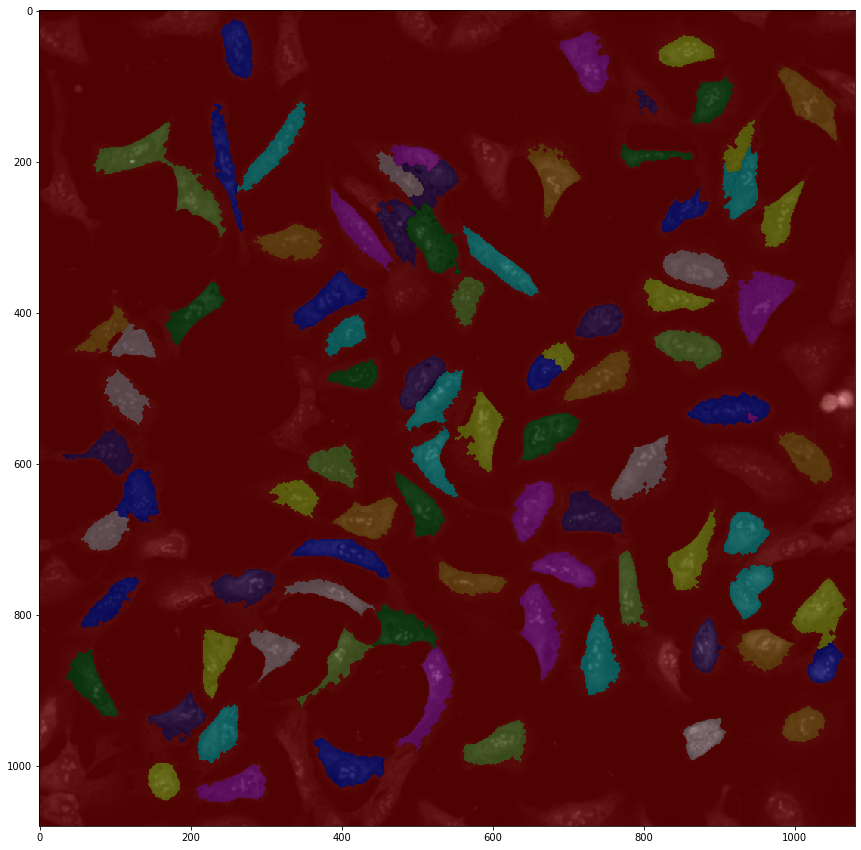

In [52]:
aphe=np.random.choice(range(1,phenotype_count+1))
aphe=7
weid=dfAnn[dfAnn[u'Phenotype '+str(aphe)]!=''].sample()['Well'].values
im=getOneImage(conn,weid)
dfCells,seg,segVisu=segImage(I)

plt.figure(figsize=(15,15))
plt.imshow(segVisu)
